# Module import

In [108]:
from netCDF4 import Dataset                             
import numpy as np                                      
import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader
import sys
import torch 
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import os
from scipy.ndimage import gaussian_filter

In [109]:
sys.path.append("/home/users/mendrika/Object-Based-LSTMConv/notebooks/model/training")
from ncast import Core2MapModel

# Choose nowcast origin and lead time (in hour)

In [110]:
year = "2020"
month = "06"
day = "01"
hour = "19"
minute = "30"

In [111]:
lead_time = 6

# Configurations

In [112]:
DISPLAY_LON_MIN = -18.5
DISPLAY_LON_MAX = -4.45
DISPLAY_LAT_MIN = 5.1
DISPLAY_LAT_MAX = 19.5

# Ground truth 

In [113]:
def update_hour(date_dict, hours_to_add, minutes_to_add):
    """
    Add hours and minutes to a datetime dictionary and return the updated dict and a generated file path.

    Args:
        date_dict     (dict): Keys: 'year', 'month', 'day', 'hour', 'minute' as strings, e.g. "01", "23"
        hours_to_add   (int): Number of hours to add.
        minutes_to_add (int): Number of minutes to add.

    Returns:
        tuple:
            - dict: Updated datetime dictionary with all fields as zero-padded strings.
            - str: File path in the format YYYY/MM/YYYYMMDDHHMM.nc
    """
    # Parse the original time
    time_obj = datetime(
        int(date_dict["year"]),
        int(date_dict["month"]),
        int(date_dict["day"]),
        int(date_dict["hour"]),
        int(date_dict["minute"])
    )

    # Add hours
    updated = time_obj + timedelta(hours=hours_to_add, minutes=minutes_to_add)

    # Format updated dictionary
    new_date_dict = {
        "year":   f"{updated.year:04d}",
        "month":  f"{updated.month:02d}",
        "day":    f"{updated.day:02d}",
        "hour":   f"{updated.hour:02d}",
        "minute": f"{updated.minute:02d}"
    }

    # Generate file path
    file_path = f"{new_date_dict['year']}/{new_date_dict['month']}/{new_date_dict['year']}{new_date_dict['month']}{new_date_dict['day']}{new_date_dict['hour']}{new_date_dict['minute']}.nc"

    return {'time': new_date_dict, 'path': file_path}

In [114]:
def load_wavelet_dataset(year, month, day, hour, minute, lead_time):
    
    nowcast_origin = {
        "year":   year,
        "month":  month,
        "day":    day,
        "hour":   hour,
        "minute": minute,
    }

    nowcast_lt = update_hour(nowcast_origin, hours_to_add=lead_time, minutes_to_add=0)["time"]

    path_core = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{nowcast_lt['year']}/{nowcast_lt['month']}"
    file = f"{path_core}/{nowcast_lt['year']}{nowcast_lt['month']}{nowcast_lt['day']}{nowcast_lt['hour']}{nowcast_lt['minute']}.nc"
    return Dataset(file, mode='r')["cores"]

In [115]:
y_min, y_max = 1403, 1914
x_min, x_max = 66, 577

In [116]:
ground_truth = load_wavelet_dataset(year, month, day, hour, minute, lead_time)[0, y_min:y_max+1, x_min:x_max+1] != 0

In [117]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons = geodata["lon"][y_min:y_max+1, x_min:x_max+1]
lats = geodata["lat"][y_min:y_max+1, x_min:x_max+1]

In [118]:
def load_zcast_input(year, month, day, hour, minute, lead_time):
    input_path_zcast = f"/work/scratch-nopw2/mendrika/OB/raw/inputs_t0"
    core_input = f"{input_path_zcast}/input-{year}{month}{day}_{hour}{minute}.pt"
    return torch.load(core_input)

In [119]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [120]:
ENSEMBLE_DIR = f"/gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t{lead_time}"

In [121]:
N_MC = 0  # MC dropout disabled

def enable_dropout(model, p=0.05):
    # keep dropout active during inference
    for m in model.modules():
        if isinstance(m, (torch.nn.Dropout, torch.nn.Dropout2d)):
            m.train()
            m.p = p

def load_models(ensemble_dir):
    models = []
    for seed in sorted(os.listdir(ensemble_dir)):
        ckpt = os.path.join(ensemble_dir, seed, "best-core2map.ckpt")
        if os.path.exists(ckpt):
            model = Core2MapModel.load_from_checkpoint(ckpt, map_location=DEVICE)
            model.eval().to(DEVICE)
            models.append(model)
            print(f"Loaded {ckpt}")
    return models

def mc_predict(model, x, n_samples=10):
    # MC dropout fully deactivated
    if n_samples == 0:
        with torch.no_grad():
            pred = torch.sigmoid(model(x))
        return pred, torch.zeros_like(pred)

    # fallback (not used when n_samples=0)
    enable_dropout(model)
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            preds.append(torch.sigmoid(model(x)))
    preds = torch.stack(preds)
    return preds.mean(0), preds.var(0)

def ensemble_mc_predict(models, x, n_mc=N_MC):
    mean_list, var_list = [], []

    for m in models:
        # deterministic forward, no dropout, no MC sampling
        mean_i, var_i = mc_predict(m, x, n_mc)
        mean_list.append(mean_i)
        var_list.append(var_i)

    mean_stack = torch.stack(mean_list)
    var_stack = torch.stack(var_list)

    mean_ens = mean_stack.mean(0)
    var_ens = var_stack.mean(0) + mean_stack.var(0)

    return mean_ens, var_ens

In [122]:
models = load_models(ENSEMBLE_DIR)
print(f"Loaded {len(models)} ensemble members.")

Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t6/seed10/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t6/seed20/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t6/seed30/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t6/seed40/best-core2map.ckpt
Loaded /gws/nopw/j04/wiser_ewsa/mrakotomanga/OB/checkpoints/WS/transformer/t6/seed50/best-core2map.ckpt
Loaded 5 ensemble members.


In [123]:
SCALER_PATH = "/home/users/mendrika/Object-Based-LSTMConv/outputs/scaler/scaler_realcores.pt"

MASK_COL_INDEX = 12
COLS_TO_SCALE = range(4, 12)

# load scaler
scaler = torch.load(SCALER_PATH, weights_only=False)
mean = np.asarray(scaler["mean"])
scale = np.asarray(scaler["scale"])

try:
    # load one instance
    zcast_input = load_zcast_input(year, month, day, hour, minute, lead_time)

    # shape: (5, 50, 13) → add batch dim → (1, 5, 50, 13)
    input_tensor = zcast_input["input_tensor"].clone().unsqueeze(0)

    # remove batch dim for scaling
    X = input_tensor[0]

    # convert to numpy
    X_np = X.numpy()

    # reshape to (250, 13)
    flat = X_np.reshape(-1, X_np.shape[-1])

    # scale all cores (real + padded)
    flat[:, COLS_TO_SCALE] = (flat[:, COLS_TO_SCALE] - mean) / scale

    # reshape back to (5, 50, 13)
    X_scaled = torch.tensor(flat.reshape(X_np.shape), dtype=torch.float32)

    # re-add batch dimension → (1, 5, 50, 13)
    input_scaled = X_scaled.unsqueeze(0)

    mean_pred, var_pred = ensemble_mc_predict(models, input_scaled.to(DEVICE))

except:
    print("No data")
    mean_pred = np.zeros((1, 1, 512, 512))

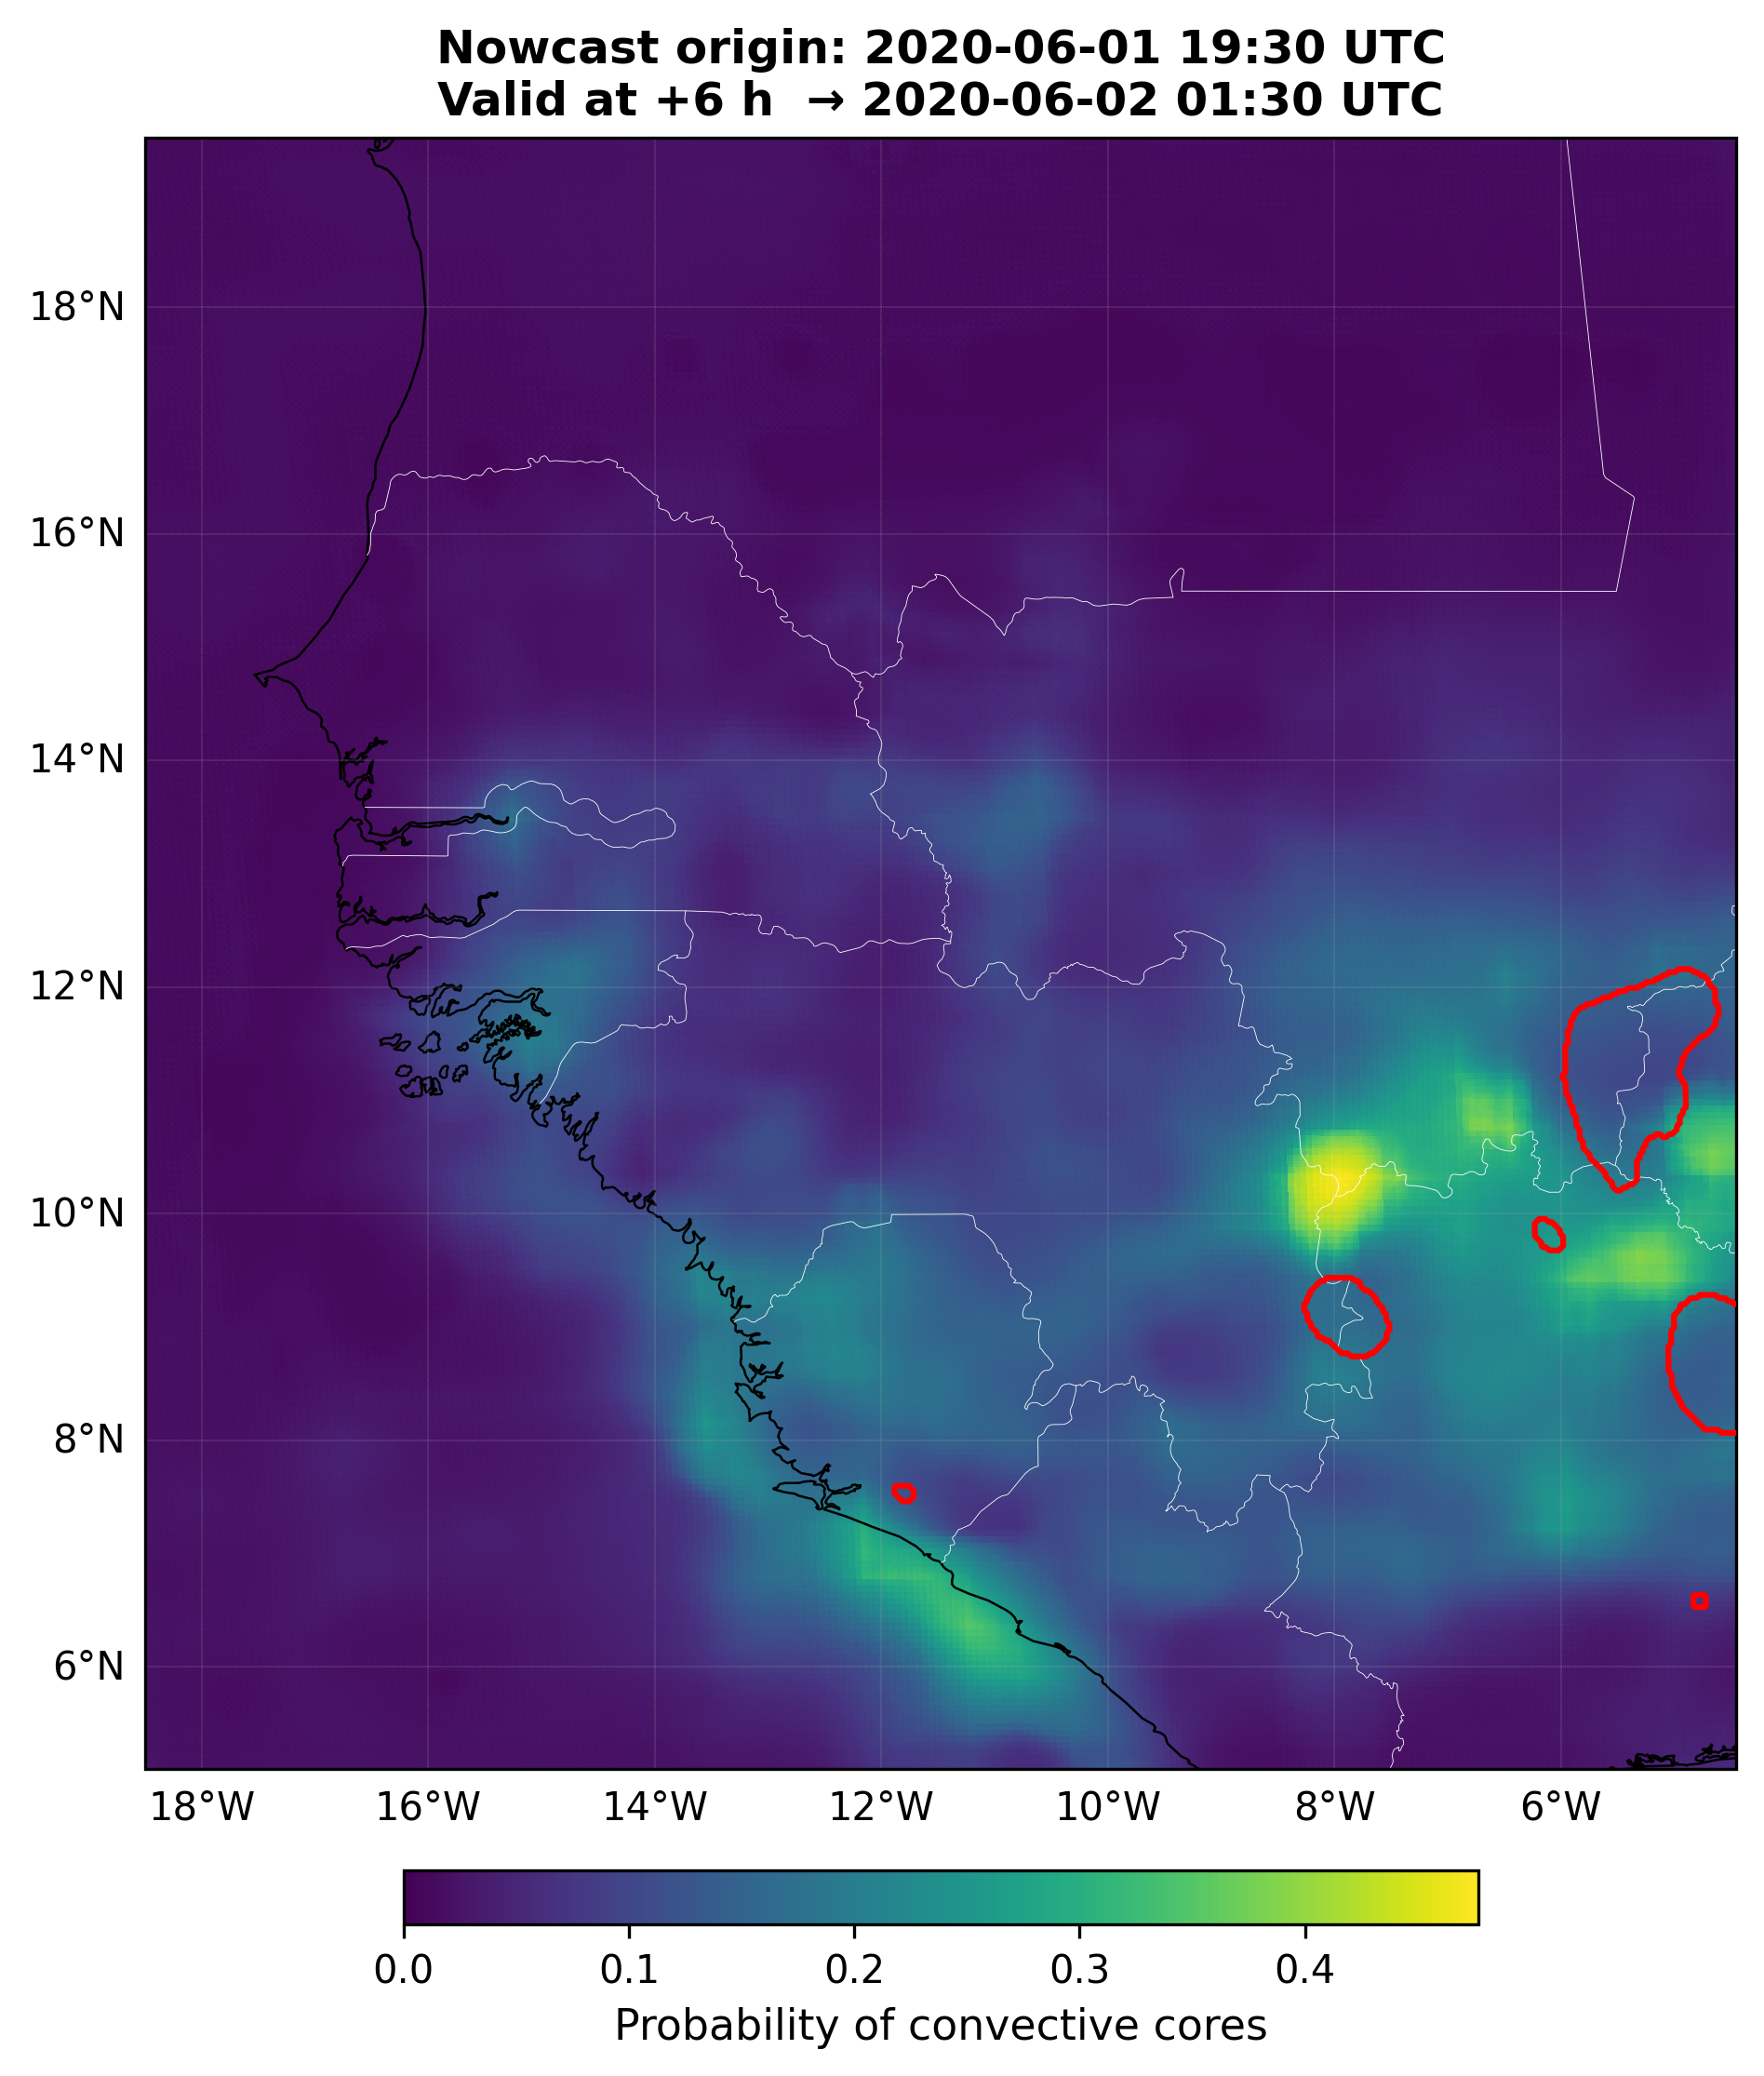

In [124]:
# compute origin and valid time
origin_dt = datetime(int(year), int(month), int(day), int(hour), int(minute))
valid_dt = origin_dt + timedelta(hours=lead_time)

# build title string
title_str = (
    f"Nowcast origin: {origin_dt:%Y-%m-%d %H:%M UTC}\n"
    f"Valid at +{lead_time} h  → {valid_dt:%Y-%m-%d %H:%M UTC}"
)

# create figure and axis
fig, ax = plt.subplots(
    1, 1, figsize=(8, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

# extent from Zambia style
ax.set_extent(
    [
        DISPLAY_LON_MIN,
        DISPLAY_LON_MAX,
        DISPLAY_LAT_MIN,
        DISPLAY_LAT_MAX
    ],
    crs=ccrs.PlateCarree()
)

# Zambia-style base map features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2)

# Western Sahel-style gridlines (only change)
gl = ax.gridlines(
    draw_labels=True,
    alpha=1,
    linestyle='--',
    linewidth=0.1
)
gl.top_labels = False
gl.right_labels = False

# mask weak probabilities
ZCAST_masked = np.ma.masked_where(mean_pred <= 0, mean_pred)

# ZCAST background
im = ax.pcolormesh(
    lons,
    lats,
    ZCAST_masked.squeeze(0).squeeze(0),
    cmap='viridis',
    vmin=0,
    vmax=np.max(ZCAST_masked),
    transform=ccrs.PlateCarree(),
    zorder=1
)

# smooth ground truth
gt_smooth = gaussian_filter(ground_truth.astype(float), sigma=0.4)

# red contour
ax.contour(
    lons,
    lats,
    gt_smooth,
    levels=[0.5],
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# colourbar
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
cbar.set_label('Probability of convective cores', fontsize=11)

# title
ax.set_title(title_str, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


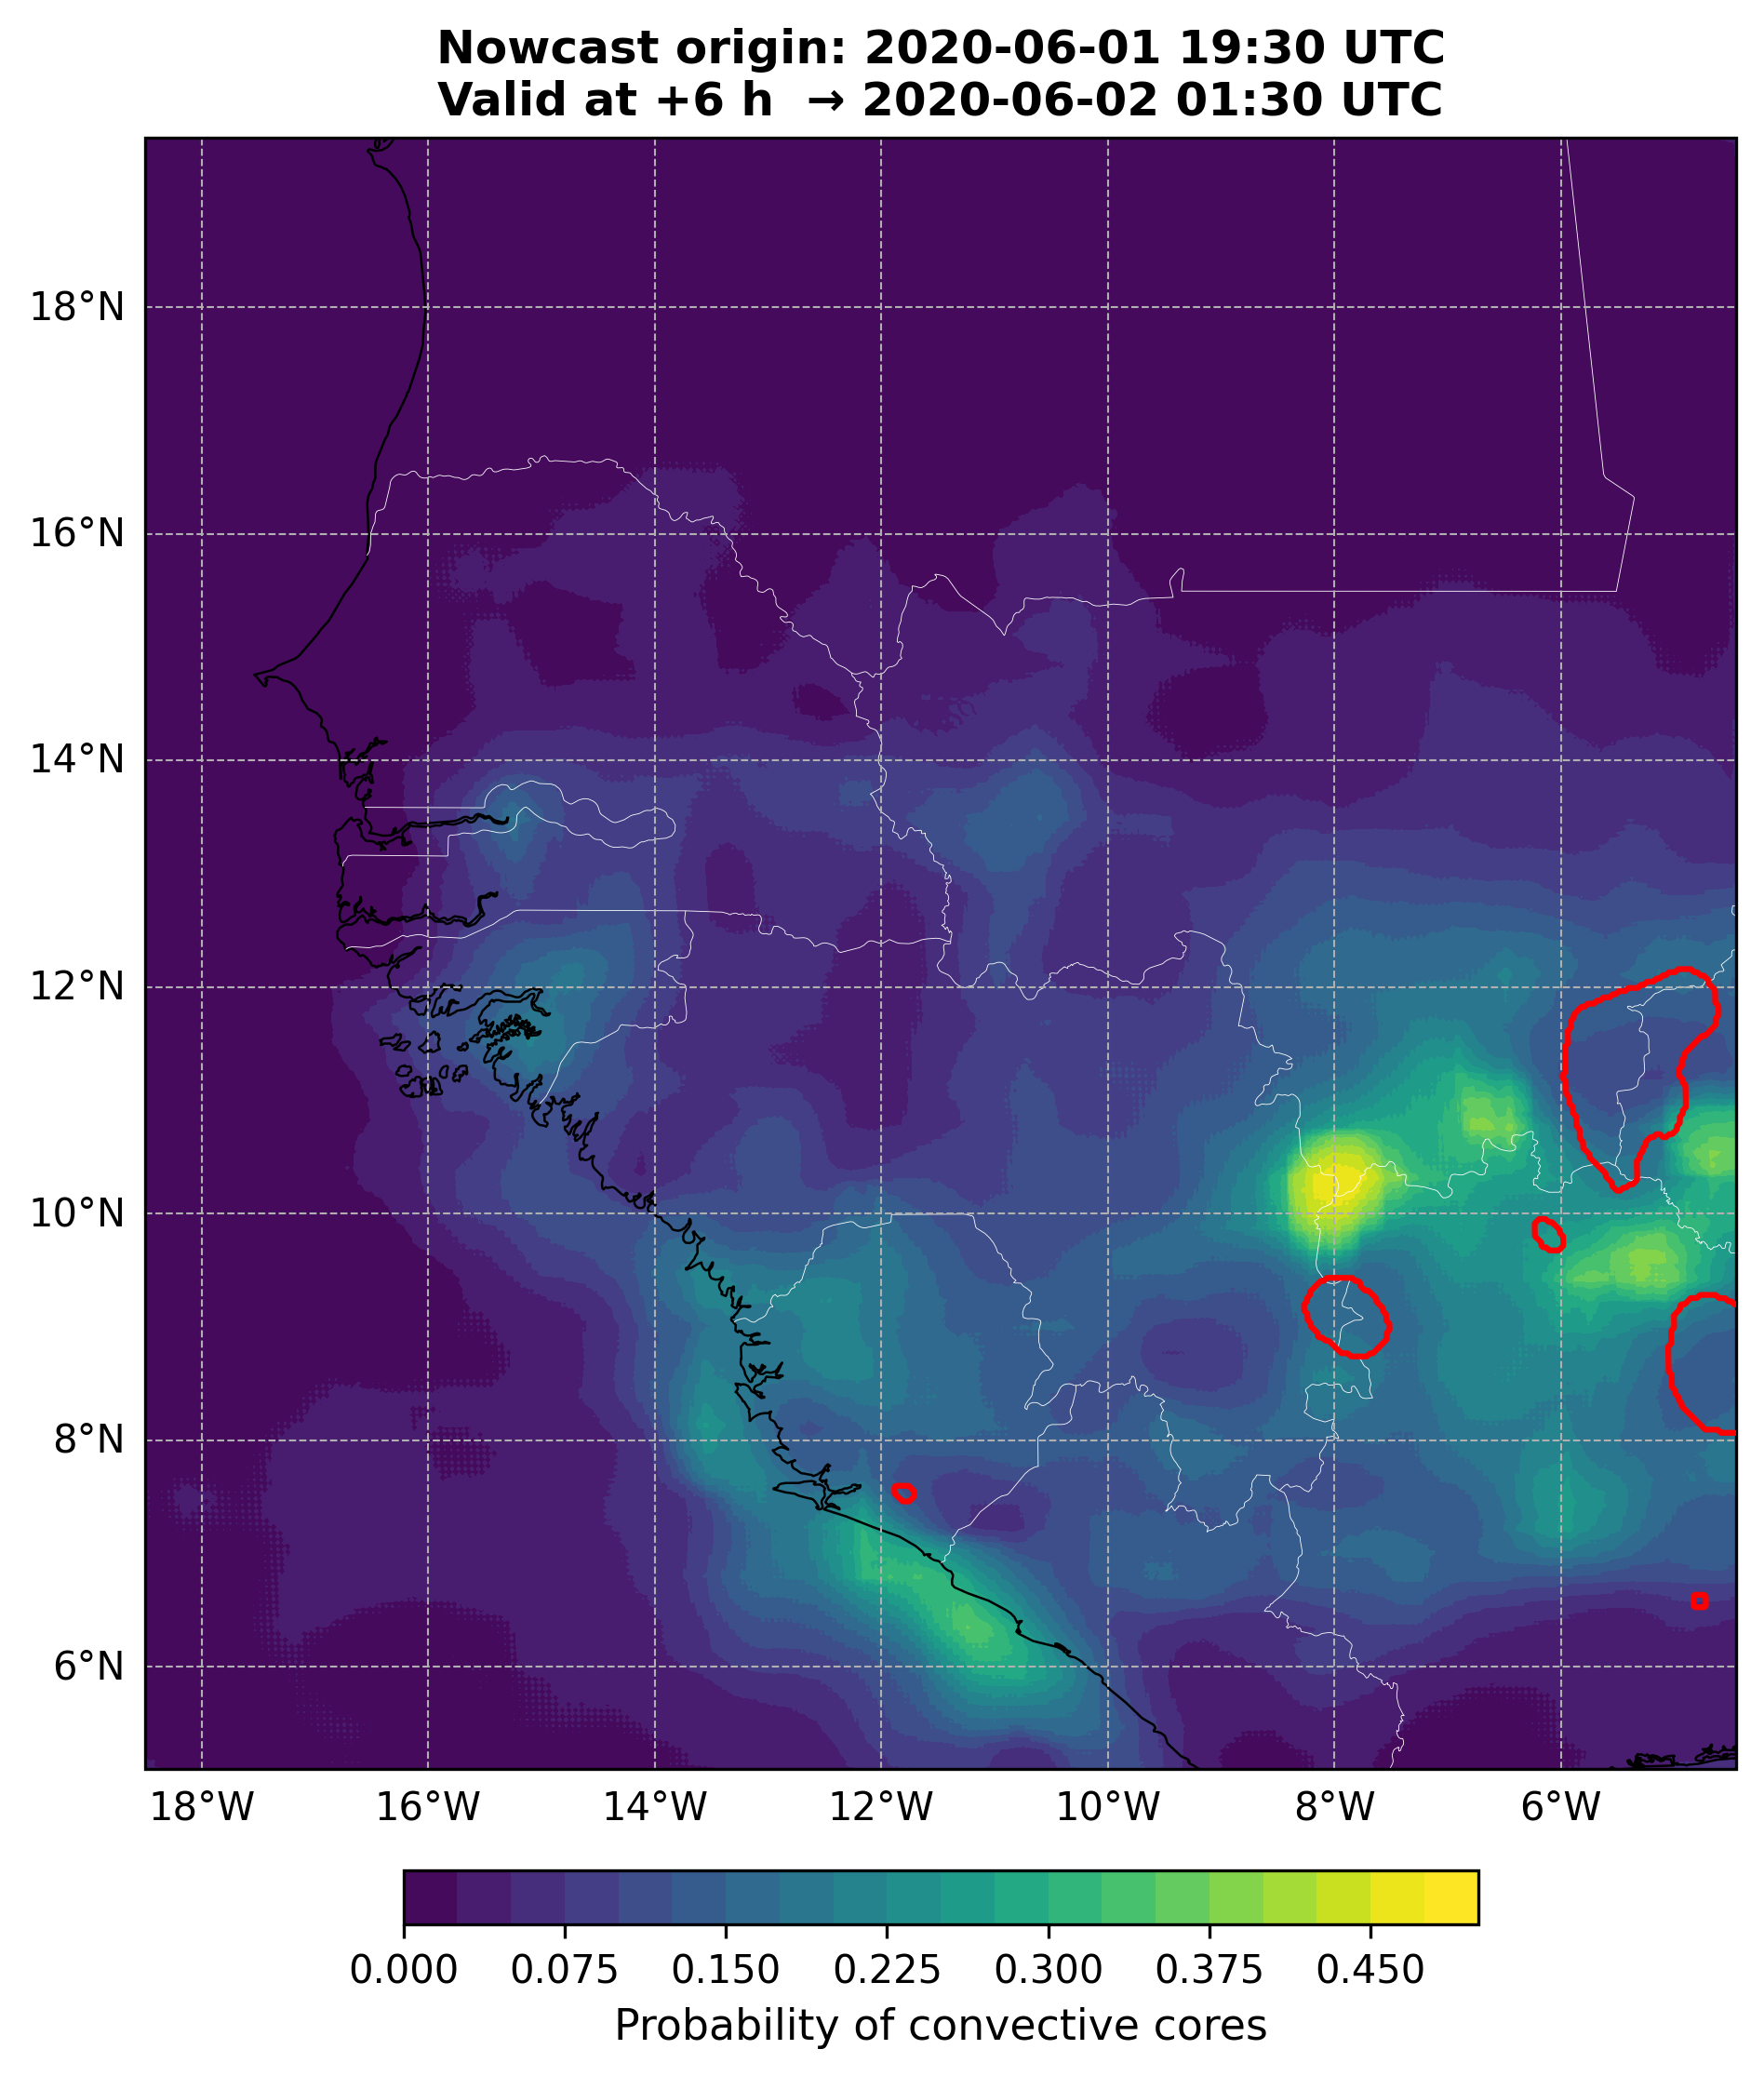

In [125]:
# create figure and axis
fig, ax = plt.subplots(
    1, 1, figsize=(8, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

# set extent
ax.set_extent(
    [
        DISPLAY_LON_MIN,
        DISPLAY_LON_MAX,
        DISPLAY_LAT_MIN,
        DISPLAY_LAT_MAX
    ],
    crs=ccrs.PlateCarree()
)

# base map features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2)

# western sahel gridlines
gl = ax.gridlines(
    draw_labels=True,
    alpha=1,
    linestyle='--',
    linewidth=0.5
)
gl.top_labels = False
gl.right_labels = False

# mask weak predictions
ZCAST_masked = np.ma.masked_where(mean_pred <= 0, mean_pred)

# filled contours for probability
im = ax.contourf(
    lons,
    lats,
    ZCAST_masked.squeeze(0).squeeze(0),
    cmap='viridis',
    levels=20,
    vmin=0,
    vmax=np.max(ZCAST_masked),
    transform=ccrs.PlateCarree(),
    zorder=1
)

# smooth binary ground truth
gt_smooth = gaussian_filter(ground_truth.astype(float), sigma=0.4)

# red outline of observed storms
ax.contour(
    lons,
    lats,
    gt_smooth,
    levels=[0.5],
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# colourbar
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='horizontal',
    shrink=0.5,
    pad=0.05
)
cbar.set_label('Probability of convective cores', fontsize=11)

# title
ax.set_title(title_str, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

In [126]:
import sys
sys.path.insert(1, "/home/users/mendrika/SSA/SA/module")
import snflics #type: ignore

# West Africa

In [127]:
def load_NFLICS_nowcast(year, month, day, hour, minute, lead_time):
    NFLICS_BaseDir = f"/gws/ssde/j25b/swift/nflics_nowcasts/{year}/{month}/{day}/{hour}{minute}"
    file = f"{NFLICS_BaseDir}/Nowcast_{year}{month}{day}{hour}{minute}_000.nc" 
    data = Dataset(file, mode='r')["Probability"][lead_time, :, :]
    return data

In [128]:
def compute_NFLICS_latlon(ny, nx, top, bottom, left, right):
    """
    Generate latitude and longitude grids for NFLICS nowcasts.

    Parameters
    ----------
    ny, nx : int
        Array shape (rows, columns) of the nowcast grid.
    top, bottom, left, right : float
        Domain boundaries in degrees (EPSG:4326).
    Returns
    -------
    NFLICS_lats, NFLICS_lons : np.ndarray
        2D latitude and longitude grids of shape (ny, nx).
    """
    # Derive pixel size dynamically to avoid mismatch
    dx = (right - left) / nx
    dy = (top - bottom) / ny

    # 1D coordinate arrays (pixel centres)
    lons_1d = left + (np.arange(nx) + 0.5) * dx
    lats_1d = top  - (np.arange(ny) + 0.5) * dy

    # 2D grids
    NFLICS_lons, NFLICS_lats = np.meshgrid(lons_1d, lats_1d)

    return NFLICS_lats, NFLICS_lons

# SADC domain
top, bottom, left, right = 19.99001, -2.018712, -23.0, 32.021806
ny, nx = 776, 1748


NFLICS_lats, NFLICS_lons = compute_NFLICS_latlon(ny, nx, top, bottom, left, right)

NFLICS_LON_MIN = np.min(NFLICS_lons)
NFLICS_LON_MAX = np.max(NFLICS_lons)
NFLICS_LAT_MIN = np.min(NFLICS_lats)
NFLICS_LAT_MAX = np.max(NFLICS_lats)

print(NFLICS_lats.shape, NFLICS_lons.shape)
print(f"Latitude range:  {NFLICS_LAT_MIN:.4f} → {NFLICS_LAT_MAX:.4f}")
print(f"Longitude range: {NFLICS_LON_MIN:.4f} → {NFLICS_LON_MAX:.4f}")

(776, 1748) (776, 1748)
Latitude range:  -2.0045 → 19.9758
Longitude range: -22.9843 → 32.0061


In [129]:
lat_min_domain = float(np.nanmin(lats))
lat_max_domain = float(np.nanmax(lats))

lon_min_domain = float(np.nanmin(lons))
lon_max_domain = float(np.nanmax(lons))

In [130]:
NFLICS_ymax, NFLICS_xmin = snflics.to_yx(lat_min_domain, lon_min_domain, NFLICS_lats, NFLICS_lons)
NFLICS_ymin, NFLICS_xmax = snflics.to_yx(lat_max_domain, lon_max_domain, NFLICS_lats, NFLICS_lons)

In [131]:
print(NFLICS_ymin, NFLICS_ymax, NFLICS_xmin, NFLICS_xmax)

9 526 100 597


In [132]:
from scipy.ndimage import zoom

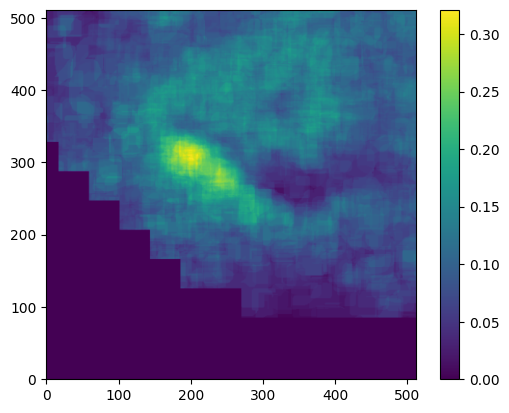

In [133]:
# load NFLICS
nflics = load_NFLICS_nowcast(year, month, day, hour, minute, lead_time)

# convert masked array to a normal ndarray (scale 0–100 → 0–1)
nflics = np.asarray(nflics, dtype=float) / 100.0

# replace invalid values with 0
nflics[nflics <= 0] = 0.0
nflics[np.isnan(nflics)] = 0.0

# clip to valid probability range
nflics = np.clip(nflics, 0.0, 1.0)

# crop to your domain (same indices for all)
nflics_crop = nflics[NFLICS_ymin:NFLICS_ymax+1,
                     NFLICS_xmin:NFLICS_xmax+1]

lats_crop = NFLICS_lats[NFLICS_ymin:NFLICS_ymax+1,
                        NFLICS_xmin:NFLICS_xmax+1]

lons_crop = NFLICS_lons[NFLICS_ymin:NFLICS_ymax+1,
                        NFLICS_xmin:NFLICS_xmax+1]

# resize to 512×512 (bilinear interpolation, order=1)
scale_y = 512 / nflics_crop.shape[0]
scale_x = 512 / nflics_crop.shape[1]

nflics_512 = zoom(nflics_crop, (scale_y, scale_x), order=1)
ws_nflics_lats_512   = zoom(lats_crop,   (scale_y, scale_x), order=1)
ws_nflics_lons_512   = zoom(lons_crop,   (scale_y, scale_x), order=1)

# plot resized data
plt.imshow(nflics_512, origin="lower")
plt.colorbar()
plt.show()

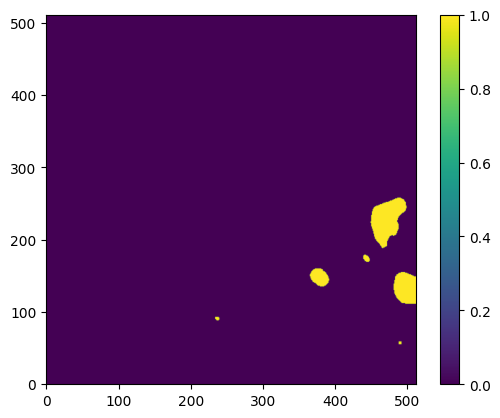

In [134]:
plt.imshow(gt_smooth, origin="lower")
plt.colorbar()

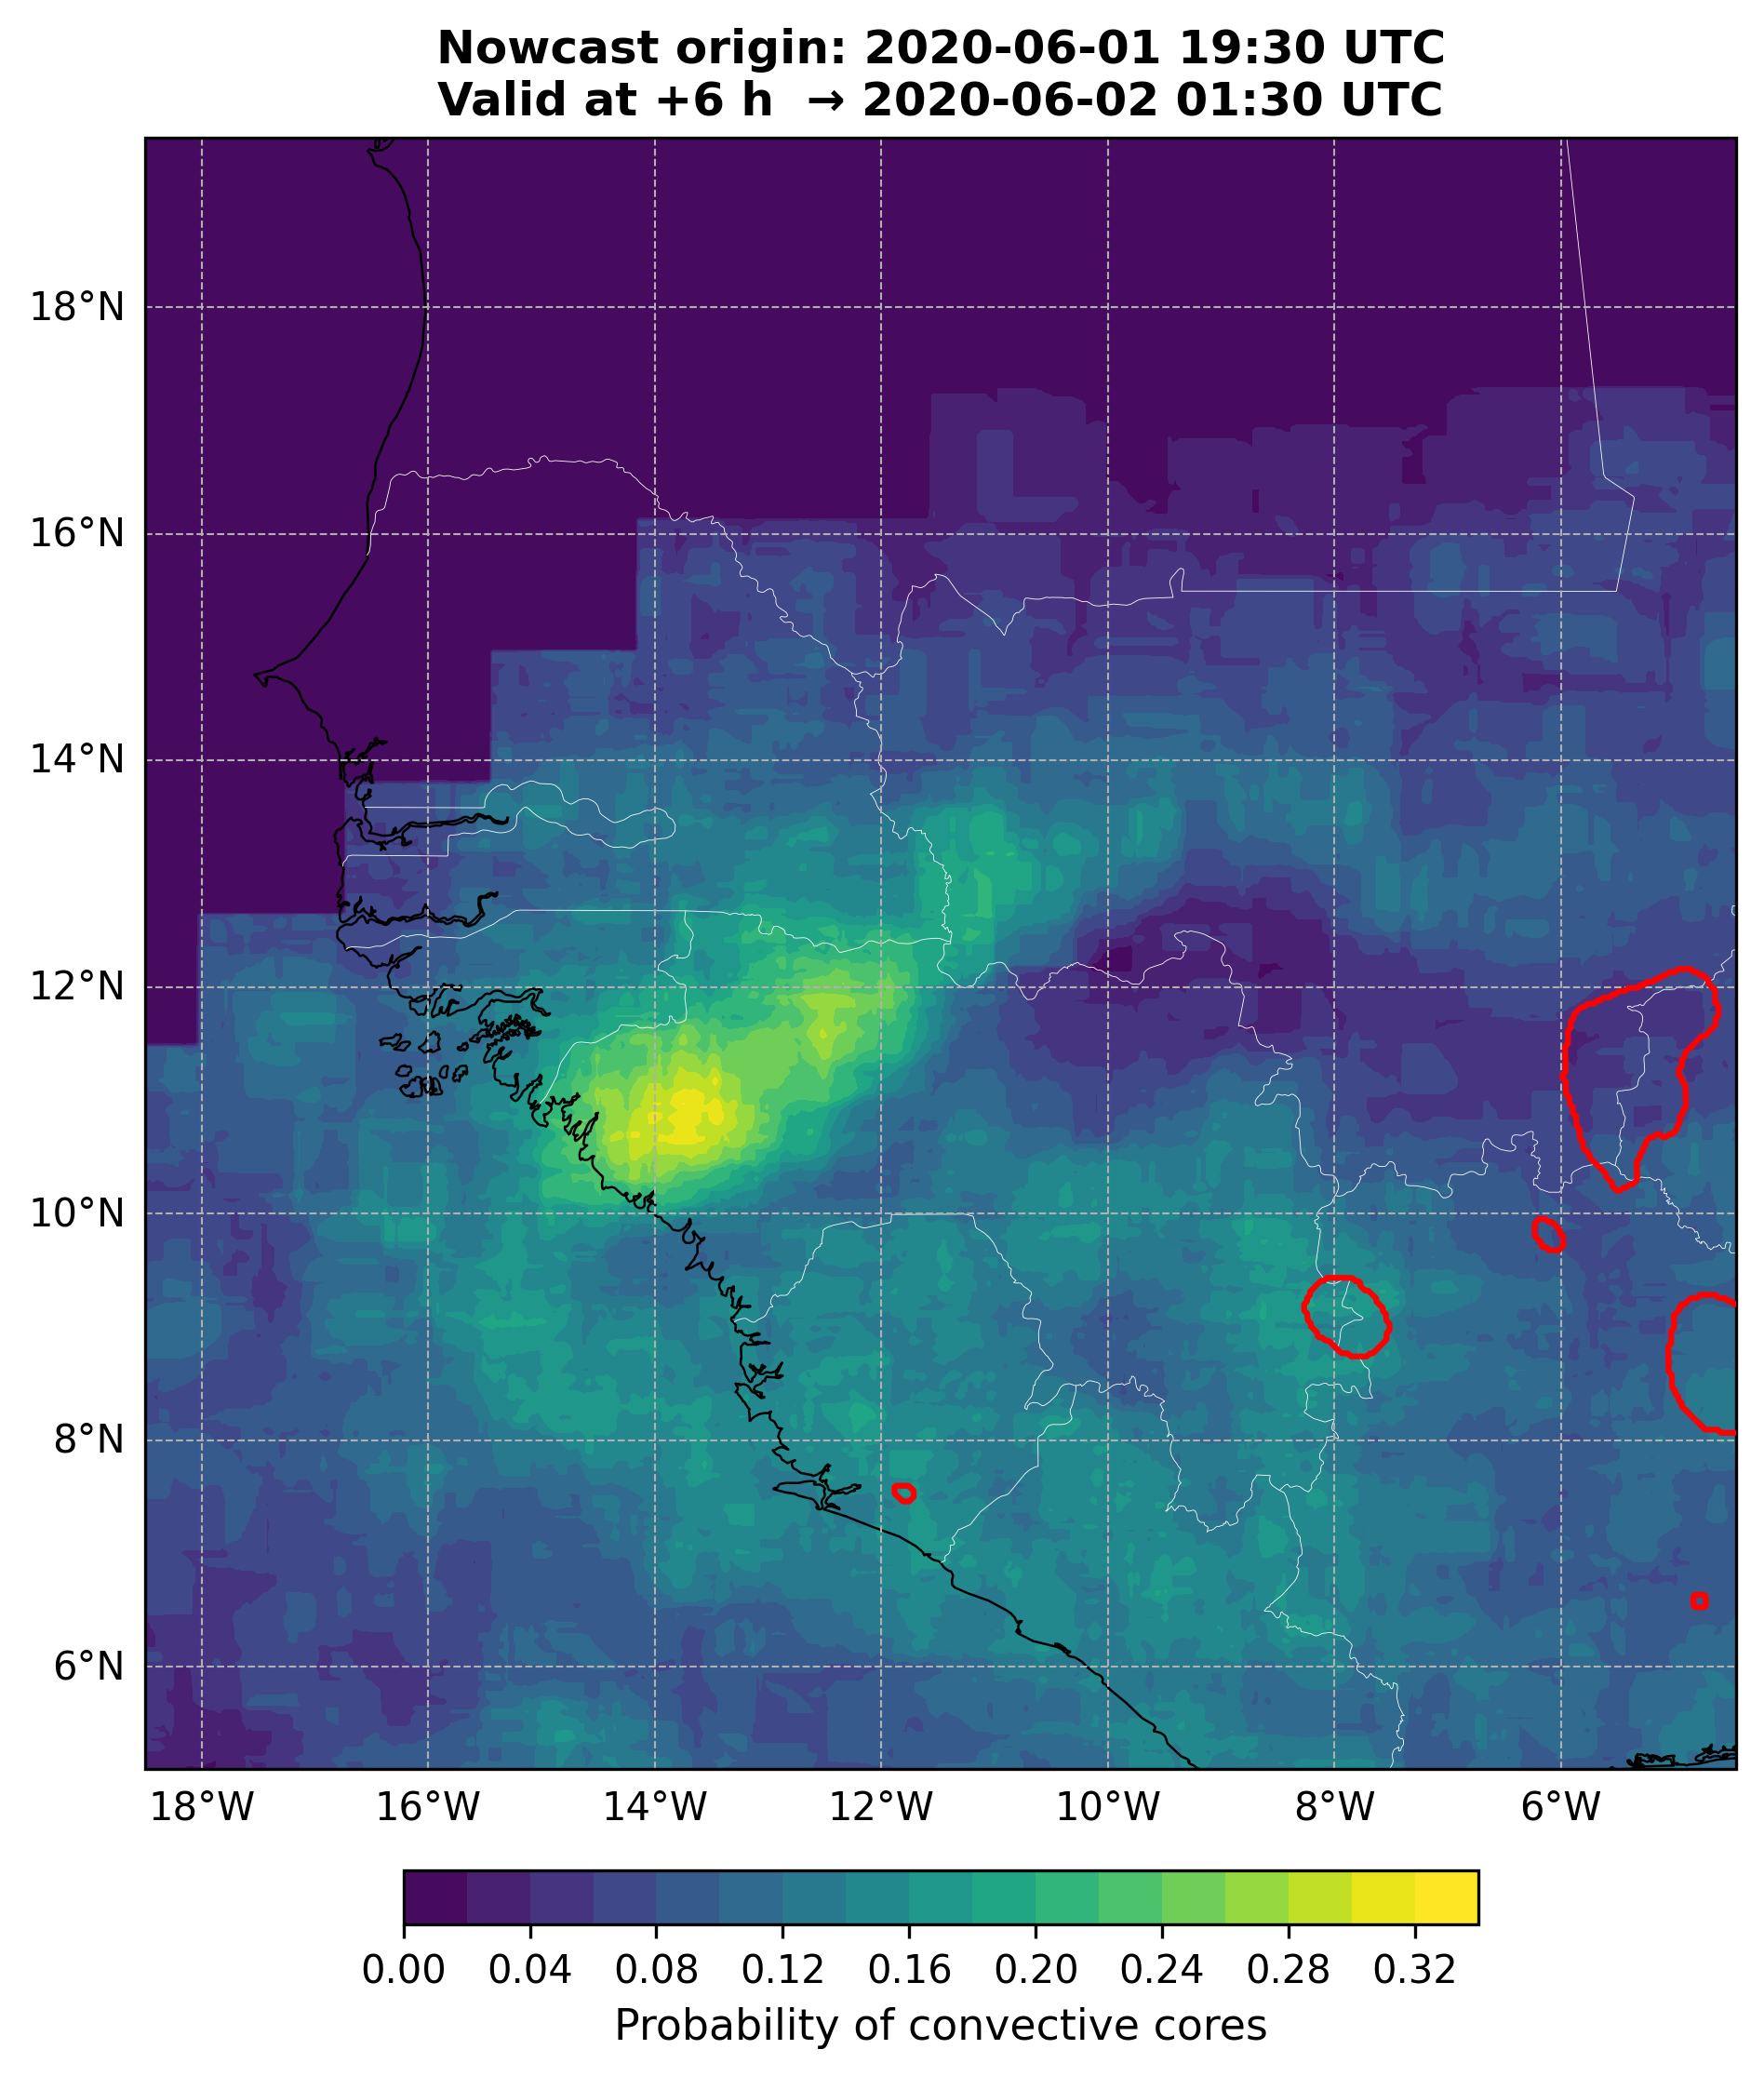

In [135]:
# create figure and axis
fig, ax = plt.subplots(
    1, 1, figsize=(8, 8),
    subplot_kw={'projection': ccrs.PlateCarree()},
    dpi=300
)

# set extent
ax.set_extent(
    [
        DISPLAY_LON_MIN,
        DISPLAY_LON_MAX,
        DISPLAY_LAT_MIN,
        DISPLAY_LAT_MAX
    ],
    crs=ccrs.PlateCarree()
)

# base map features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='white', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linewidth=0.2)

# western sahel gridlines
gl = ax.gridlines(
    draw_labels=True,
    alpha=1,
    linestyle='--',
    linewidth=0.5
)
gl.top_labels = False
gl.right_labels = False

# mask weak predictions
ZCAST_masked = np.ma.masked_where(mean_pred <= 0, mean_pred)

# filled contours for probability
im = ax.contourf(
    ws_nflics_lons_512,
    ws_nflics_lats_512,
    nflics_512,
    cmap='viridis',
    levels=20,
    vmin=0,
    vmax=np.max(nflics_512),
    transform=ccrs.PlateCarree(),
    zorder=1
)

# smooth binary ground truth
gt_smooth = gaussian_filter(ground_truth.astype(float), sigma=0.4)

# red outline of observed storms
ax.contour(
    lons,
    lats,
    gt_smooth,
    levels=[0.5],
    colors='red',
    linewidths=1.5,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# colourbar
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation='horizontal',
    shrink=0.5,
    pad=0.05
)
cbar.set_label('Probability of convective cores', fontsize=11)

# title
ax.set_title(title_str, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()